In [1]:
import typing as t
import pathlib
import os
import pickle
import collections
import timeit

import optimum
import optimum.onnxruntime
import onnxruntime
import onnx
import datasets
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm.auto
import pandas as pd

import segmentador
import segmentador.optimize
import eval_model

%load_ext autoreload
%autoreload 2

PERFORMANCE_LOGS_DIR = "performance_logs"
pathlib.Path(PERFORMANCE_LOGS_DIR).mkdir(exist_ok=True, parents=True)

QUANTIZED_MODELS_DIR = "quantized_models"
pathlib.Path(QUANTIZED_MODELS_DIR).mkdir(exist_ok=True, parents=True)

In [2]:
curated_df = datasets.Dataset.from_file(
    "../data/refined_datasets/df_tokenized_split_0_120000_6000/"
    "combined_test_48_parts_1036_instances/dataset.arrow"
)

curated_df_subsample = curated_df.shard(num_shards=200, index=0)

## Creating LSTM Quantization

In [3]:
segmenter_lstm = segmentador.LSTMSegmenter(
    uri_model="../pretrained_segmenter_model/512_6000_1_lstm/checkpoints/epoch=3-step=3591.ckpt",
    uri_tokenizer="../tokenizers/6000_subwords",
    device="cpu",
)

### With Torch format

In [4]:
quantized_lstm_torch_paths = segmentador.optimize.quantize_model(
    segmenter_lstm,
    model_output_format="torch",
    check_cached=False,
    verbose=True,
)

Saved quantized Pytorch module (Torch format) in './quantized_models/q_num_layers_1_vocab_size_6000_lstm_model.pt'. To use it, load a LSTM segmenter model as:

LSTMSegmenter(
   uri_model='./quantized_models/q_num_layers_1_vocab_size_6000_lstm_model.pt',
   uri_tokenizer='../tokenizers/6000_subwords',
   from_quantized_weights=True,
   ...,
)


In [5]:
segmenter_lstm_torch_quantized = segmentador.LSTMSegmenter(
   uri_model=quantized_lstm_torch_paths.output_uri,
   uri_tokenizer='../tokenizers/6000_subwords',
   from_quantized_weights=True,
)

In [6]:
segmenter_lstm_torch_quantized(curated_df_subsample, show_progress_bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]

['INDICAÇÃO Nº DE 2008 ( Do Sr. Hermes Parcianello )',
 'Indica ao Ministério da Educação a inclusão no ProInfância do município de LARANJEIRAS DO SUL, no estado do Paraná.',
 'Excelentíssimo Senhor Ministro de Estado da Educação, Considerando que a construção de creches e escolas de educação infantil e a reestruturação e aquisição de equipamentos para a rede física escolar desse nível educacional são indispensáveis à melhoria da educação. Considerando um grande percentual de mulheres chefes de família com filhos menores que necessitam de local adequado para deixar seus filhos e que o Programa disponibiliza o atendimento de até 120 crianças em período integral ou até 240 crianças, se distribuídos em turnos matutinos e vespertinos. Considerando que o município ao ser atendido pelo Programa priorizará a acessibilidade, fazendo as adequações necessárias a fim de permitir seu uso por portadores de necessidades especiais. Considerando que a edificação será composta de um bloco administrativ

### With ONNX format

In [7]:
quantized_lstm_onnx_paths = segmentador.optimize.quantize_model(
    segmenter_lstm,
    model_output_format="onnx",
    check_cached=False,
    verbose=True,
)

/media/nvme/segmentador/venvs/env3.9.10/lib/python3.9/site-packages/torch/onnx/symbolic_opset9.py:2188: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn("Exporting a model to ONNX with a batch_size other than 1, " +
/media/nvme/segmentador/venvs/env3.9.10/lib/python3.9/site-packages/torch/onnx/symbolic_helper.py:719: UserWarning: allowzero=0 by default. In order to honor zero value in shape use allowzero=1
  warnings.warn("allowzero=0 by default. In order to honor zero value in shape use allowzero=1")
2022-04-12 11:27:05.195583716 [W:onnxruntime:, inference_session.cc:1546 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model ma

Saved quantized Pytorch module (ONNX format) in './quantized_models/q_hidden_layer_dim_512_vocab_size_6000_num_layers_1_lstm_model_99_opt_level.onnx'. To use it, load a LSTM segmenter model as:

segmentador.optimize.quantize.ONNXLSTMSegmenter(
   uri_model='./quantized_models/q_hidden_layer_dim_512_vocab_size_6000_num_layers_1_lstm_model_99_opt_level.onnx',
   uri_tokenizer='../tokenizers/6000_subwords',
   ...,
)


In [8]:
segmenter_lstm_onnx_quantized = segmentador.optimize.ONNXLSTMSegmenter(
   uri_model=quantized_lstm_onnx_paths.output_uri,
   uri_tokenizer=segmenter_lstm.tokenizer.name_or_path,
)

In [9]:
segmenter_lstm_onnx_quantized(curated_df_subsample, show_progress_bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]

['INDICAÇÃO Nº DE 2008 ( Do Sr. Hermes Parcianello )',
 'Indica ao Ministério da Educação a inclusão no ProInfância do município de LARANJEIRAS DO SUL, no estado do Paraná.',
 'Excelentíssimo Senhor Ministro de Estado da Educação, Considerando que a construção de creches e escolas de educação infantil e a reestruturação e aquisição de equipamentos para a rede física escolar desse nível educacional são indispensáveis à melhoria da educação. Considerando um grande percentual de mulheres chefes de família com filhos menores que necessitam de local adequado para deixar seus filhos e que o Programa disponibiliza o atendimento de até 120 crianças em período integral ou até 240 crianças, se distribuídos em turnos matutinos e vespertinos. Considerando que o município ao ser atendido pelo Programa priorizará a acessibilidade, fazendo as adequações necessárias a fim de permitir seu uso por portadores de necessidades especiais. Considerando que a edificação será composta de um bloco administrativ

## Creating BERT Quantization

In [10]:
segmenter_bert = segmentador.BERTSegmenter(
    uri_model="../pretrained_segmenter_model/2_6000_layer_model/",
    device="cpu",
)

In [11]:
quantized_bert_paths = segmentador.optimize.quantize_model(
    segmenter_bert,
    check_cached=False,
    verbose=True,
)

2022-04-12 11:27:08.202168757 [W:onnxruntime:, inference_session.cc:1546 Initialize] Serializing optimized model with Graph Optimization level greater than ORT_ENABLE_EXTENDED and the NchwcTransformer enabled. The generated model may contain hardware specific optimizations, and should only be used in the same environment the model was optimized in.


failed in shape inference <class 'AssertionError'>
failed in shape inference <class 'AssertionError'>
Saved quantized BERT (ONNX format) in './quantized_models/q_num_layers_2_vocab_size_6000_bert_model_99_opt_level.onnx', and its configuration file in './quantized_models/q_num_layers_2_vocab_size_6000_bert_model_99_opt_level.config'. To use it, load a BERT segmenter model as:

segmentador.optimize.quantize.ONNXBERTSegmenter(
   uri_model='./quantized_models/q_num_layers_2_vocab_size_6000_bert_model_99_opt_level.onnx',
   uri_tokenizer='../pretrained_segmenter_model/2_6000_layer_model/',
   uri_onnx_config='./quantized_models/q_num_layers_2_vocab_size_6000_bert_model_99_opt_level.config',
   ...,
)


In [12]:
segmenter_bert_quantized = segmentador.optimize.ONNXBERTSegmenter(
   uri_model=quantized_bert_paths.output_uri,
   uri_tokenizer=segmenter_bert.tokenizer.name_or_path,
   uri_onnx_config=quantized_bert_paths.onnx_config_uri,
)

In [13]:
segmenter_bert_quantized(curated_df_subsample, show_progress_bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]

['INDICAÇÃO Nº DE 2008 ( Do Sr. Hermes Parcianello )',
 'Indica ao Ministério da Educação a inclusão no ProInfância do município de LARANJEIRAS DO SUL, no estado do Paraná.',
 'Excelentíssimo Senhor Ministro de Estado da Educação, Considerando que a construção de creches e escolas de educação infantil e a reestruturação e aquisição de equipamentos para a rede física escolar desse nível educacional são indispensáveis à melhoria da educação. Considerando um grande percentual de mulheres chefes de família com filhos menores que necessitam de local adequado para deixar seus filhos e que o Programa disponibiliza o atendimento de até 120 crianças em período integral ou até 240 crianças, se distribuídos em turnos matutinos e vespertinos. Considerando que o município ao ser atendido pelo Programa priorizará a acessibilidade, fazendo as adequações necessárias a fim de permitir seu uso por portadores de necessidades especiais. Considerando que a edificação será composta de um bloco administrativ

## Validating performance of distinct configurations

### Collecting results

In [14]:
def validate(
    model,
    moving_window_size: int = 1024,
    window_shift_size: float = 0.5,
    batch_size: int = 64,
    num_shards: t.Optional[int] = None,
    repeats: int = 5,
) -> dict[str, float]:
    
    sharded_df = curated_df
    
    if num_shards is not None:
        sharded_df = curated_df.shard(num_shards=num_shards, index=0)
    
    min_t_delta = np.inf
    
    for _ in range(repeats):
        t_start = timeit.time.perf_counter()

        logits = model(
            sharded_df,
            batch_size=batch_size,
            return_logits=True,
            show_progress_bar=False,
            window_shift_size=window_shift_size,
            moving_window_size=moving_window_size,
        ).logits

        t_delta = timeit.time.perf_counter() - t_start
        
        min_t_delta = min(min_t_delta, t_delta)
    
    metrics = eval_model.compute_metrics(
        ([logits], [np.concatenate(sharded_df["labels"])]),
    )
    metrics["approx_inference_time"] = min_t_delta
    
    return metrics

In [15]:
quantized_model_paths: dict[tuple[t.Type, str, int], tuple[str, ...]] = {}

for base_model in (segmenter_bert, segmenter_lstm):
    for model_output_format in ("onnx", "torch"):
        
        if base_model == segmenter_bert and model_output_format == "torch":
            continue
        
        optimization_levels = (0, 1, 2, 99) if model_output_format == "onnx" else (0,)
        
        for optimization_level in optimization_levels:
            try:
                output_paths = segmentador.optimize.quantize_model(
                    model=base_model,
                    quantized_model_dirpath=QUANTIZED_MODELS_DIR,
                    model_output_format=model_output_format,
                    optimization_level=optimization_level,
                    check_cached=True,
                    verbose=False,
                )
                
            except onnx.shape_inference.InferenceError as err:
                output_paths = None
            
            if output_paths:
                key = (type(base_model), model_output_format, optimization_level)
                quantized_model_paths[key] = output_paths

In [16]:
num_shards = None

fn_format_key = lambda *vals: "\n".join(map(str, [*vals]))

all_results: dict[tuple[t.Type, str, int], dict[str, float]] = {
    fn_format_key("bert", "torch", "-"): {
        **validate(
            segmenter_bert,
            num_shards=num_shards,
            moving_window_size=512,
            window_shift_size=0.25,
        ),
        "config_opt_level": "-",
        "config_output_format": "torch",
        "config_model_type": "bert",
    },
    fn_format_key("lstm", "torch", "-"): {
        **validate(
            segmenter_lstm,
            num_shards=num_shards,
            moving_window_size=1024,
            window_shift_size=0.5,
        ),
        "config_opt_level": "-",
        "config_output_format": "torch",
        "config_model_type": "lstm",
    }
}

In [21]:
for config, paths in tqdm.auto.tqdm(quantized_model_paths.items()):
    model_type, output_format, opt_level = config
    
    algorithm = "lstm" if model_type == segmentador.segmenter.LSTMSegmenter else "bert"
    
    res: dict[str, float] = {}
    
    res["config_opt_level"] = opt_level
    res["config_output_format"] = output_format
    res["config_model_type"] = algorithm
    
    new_key = fn_format_key(algorithm, output_format, opt_level)
    
    if new_key in all_results:
        continue
    
    if output_format == "onnx":
        if model_type == segmentador.LSTMSegmenter:
            model_to_validate = segmentador.optimize.ONNXLSTMSegmenter(
                uri_model=quantized_lstm_onnx_paths.output_uri,
                uri_tokenizer=segmenter_lstm.tokenizer.name_or_path,
            )
            
        else:
            model_to_validate = segmentador.optimize.ONNXBERTSegmenter(
                uri_model=paths.output_uri,
                uri_tokenizer=segmenter_bert.tokenizer.name_or_path,
                uri_onnx_config=paths.onnx_config_uri,
            )
            
    else:
        model_to_validate = segmentador.LSTMSegmenter(
            uri_model=paths.output_uri,
            uri_tokenizer=segmenter_lstm.tokenizer.name_or_path,
            from_quantized_weights=True,
            device="cpu",
        )
    
    if algorithm == "bert":
        kwargs = dict(
            moving_window_size=512,
            window_shift_size=0.25,
        )
        
    else:
        kwargs = dict(
            moving_window_size=1024,
            window_shift_size=0.5,
        )
    
    res.update(validate(model_to_validate, num_shards=num_shards, **kwargs))
    
    all_results[new_key] = res

  0%|          | 0/8 [00:00<?, ?it/s]

In [22]:
df_all_results = pd.DataFrame.from_dict(all_results).T
df_all_results.sort_values(
    by="approx_inference_time",
    axis=0,
    ascending=False,
    inplace=True,
)

df_all_results.to_csv(
    path_or_buf=os.path.join(PERFORMANCE_LOGS_DIR, "perf_cpu_multithread.csv"),
    encoding="utf-8",
)

### Analysing results

In [23]:
df_all_results = pd.read_csv(
    os.path.join(PERFORMANCE_LOGS_DIR, "perf_cpu_multithread.csv"),
    index_col=0,
    header=0,
)
df_all_results[["per_cls_precision_1", "per_cls_recall_1", "approx_inference_time"]]

,per_cls_precision_1,per_cls_recall_1,approx_inference_time
bert\ntorch\n-,0.908839,0.962137,277.758002
bert\nonnx\n1,0.909184,0.961810,170.028097
bert\nonnx\n2,0.909184,0.961810,165.884593
bert\nonnx\n99,0.909184,0.961810,165.335203
lstm\ntorch\n-,0.987586,0.952127,48.873123
lstm\ntorch\n0,0.987695,0.951909,36.528978
lstm\nonnx\n1,0.987363,0.952127,25.069775
lstm\nonnx\n0,0.987363,0.952127,24.624060
lstm\nonnx\n2,0.987363,0.952127,24.195943
lstm\nonnx\n99,0.987363,0.952127,23.981962


In [24]:
score_p = df_all_results["per_cls_precision_1"]
score_r = df_all_results["per_cls_recall_1"]

aux_df = np.vstack((
    list(zip(df_all_results.index, ["Precision $c_{1}$"] * len(score_p), score_p.values)),
    list(zip(df_all_results.index, ["Recall $c_{1}$"] * len(score_r), score_r.values)),
))

cols = ["Config", "Metric", "Score"]
lineplot_df = pd.DataFrame(aux_df, columns=cols)
lineplot_df["Score"] = lineplot_df["Score"].astype(float)

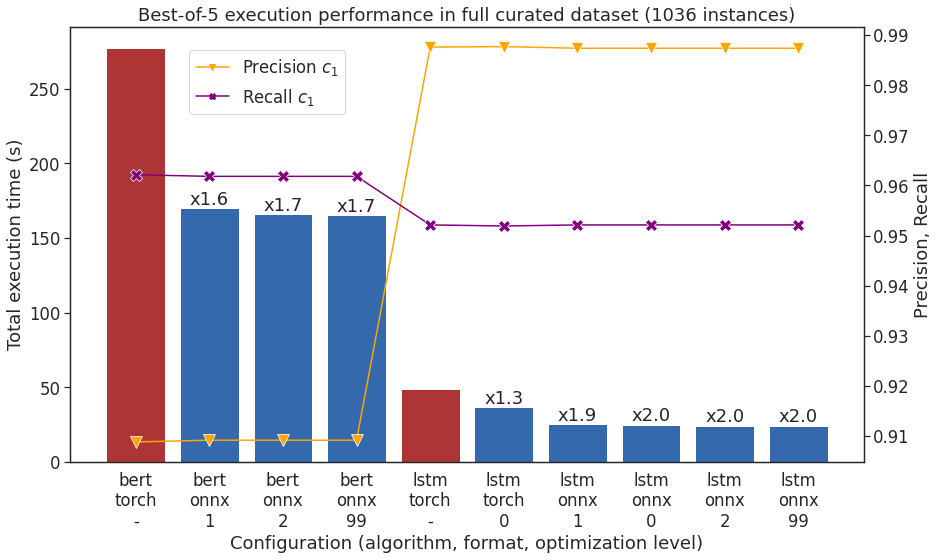

In [78]:
sns.set_theme(
    context="notebook",
    style="white",
    font_scale=1.5,
)

fig, ax1 = plt.subplots(1, figsize=(14.222, 8))
ax2 = ax1.twinx()

fn_hex_to_tuple = lambda hex_v: tuple(int(hex_v[i:i+2], base=16)/255 for i in range(0, 6, 2))

ax_sns_barplot = sns.barplot(
    x=df_all_results.index,
    y="approx_inference_time",
    ax=ax1,
    data=df_all_results,
    palette=[
        fn_hex_to_tuple("C12121")
        if opt_level == "-"
        else fn_hex_to_tuple("2167C1")
        for opt_level in df_all_results["config_opt_level"]
    ],
)

ax_sns_lineplot = sns.lineplot(
    x="Config",
    y="Score",
    hue="Metric",
    style="Metric",
    ax=ax2,
    data=lineplot_df,
    legend="full",
    dashes=False,
    markers=["v", "X"],
    markersize=12,
    palette=["orange", "purple"],
)

plt.legend(loc=(0.15, 0.8))

ax_sns_lineplot.set_ylabel("Precision, Recall")

ax_sns_barplot.set_title(
    f"Best-of-5 execution performance in full curated dataset ({curated_df.shape[0]} instances)"
)
ax_sns_barplot.set_ylabel("Total execution time (s)");
ax_sns_barplot.set_xlabel("Configuration (algorithm, format, optimization level)");

base_exec_perf_bert = df_all_results.loc[
    (df_all_results[["config_opt_level", "config_model_type"]] == ("-", "bert")).all(axis="columns"),
    "approx_inference_time",
]

base_exec_perf_lstm = df_all_results.loc[
    (df_all_results[["config_opt_level", "config_model_type"]] == ("-", "lstm")).all(axis="columns"),
    "approx_inference_time",
]

speed_ups = np.asfarray([
    (base_exec_perf_bert if model == "bert" else base_exec_perf_lstm) / inf_time
    for inf_time, model in df_all_results[["approx_inference_time", "config_model_type"]].values
]).squeeze()

ax_sns_barplot.bar_label(
    ax_sns_barplot.containers[0],
    labels=map(lambda x: f"x{x:.1f}" if x > 1.0 else "", speed_ups),
);

fig.savefig(fname=os.path.join(PERFORMANCE_LOGS_DIR, "perf_plot.pdf"), format="pdf", bbox_inches="tight")

### Hardware specification for experiment above
- Architecture:            x86_64
  - CPU op-mode(s):        32-bit, 64-bit
  - Address sizes:         39 bits physical, 48 bits virtual
  - Byte Order:            Little Endian
- CPU(s):                  12
  - On-line CPU(s) list:   0-11
- Vendor ID:               GenuineIntel
  - Model name:            Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
    - CPU family:          6
    - Model:               158
    - Thread(s) per core:  2
    - Core(s) per socket:  6
    - Socket(s):           1
    - Stepping:            10
    - CPU max MHz:         4500,0000
    - CPU min MHz:         800,0000
    - BogoMIPS:            5202.65